In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


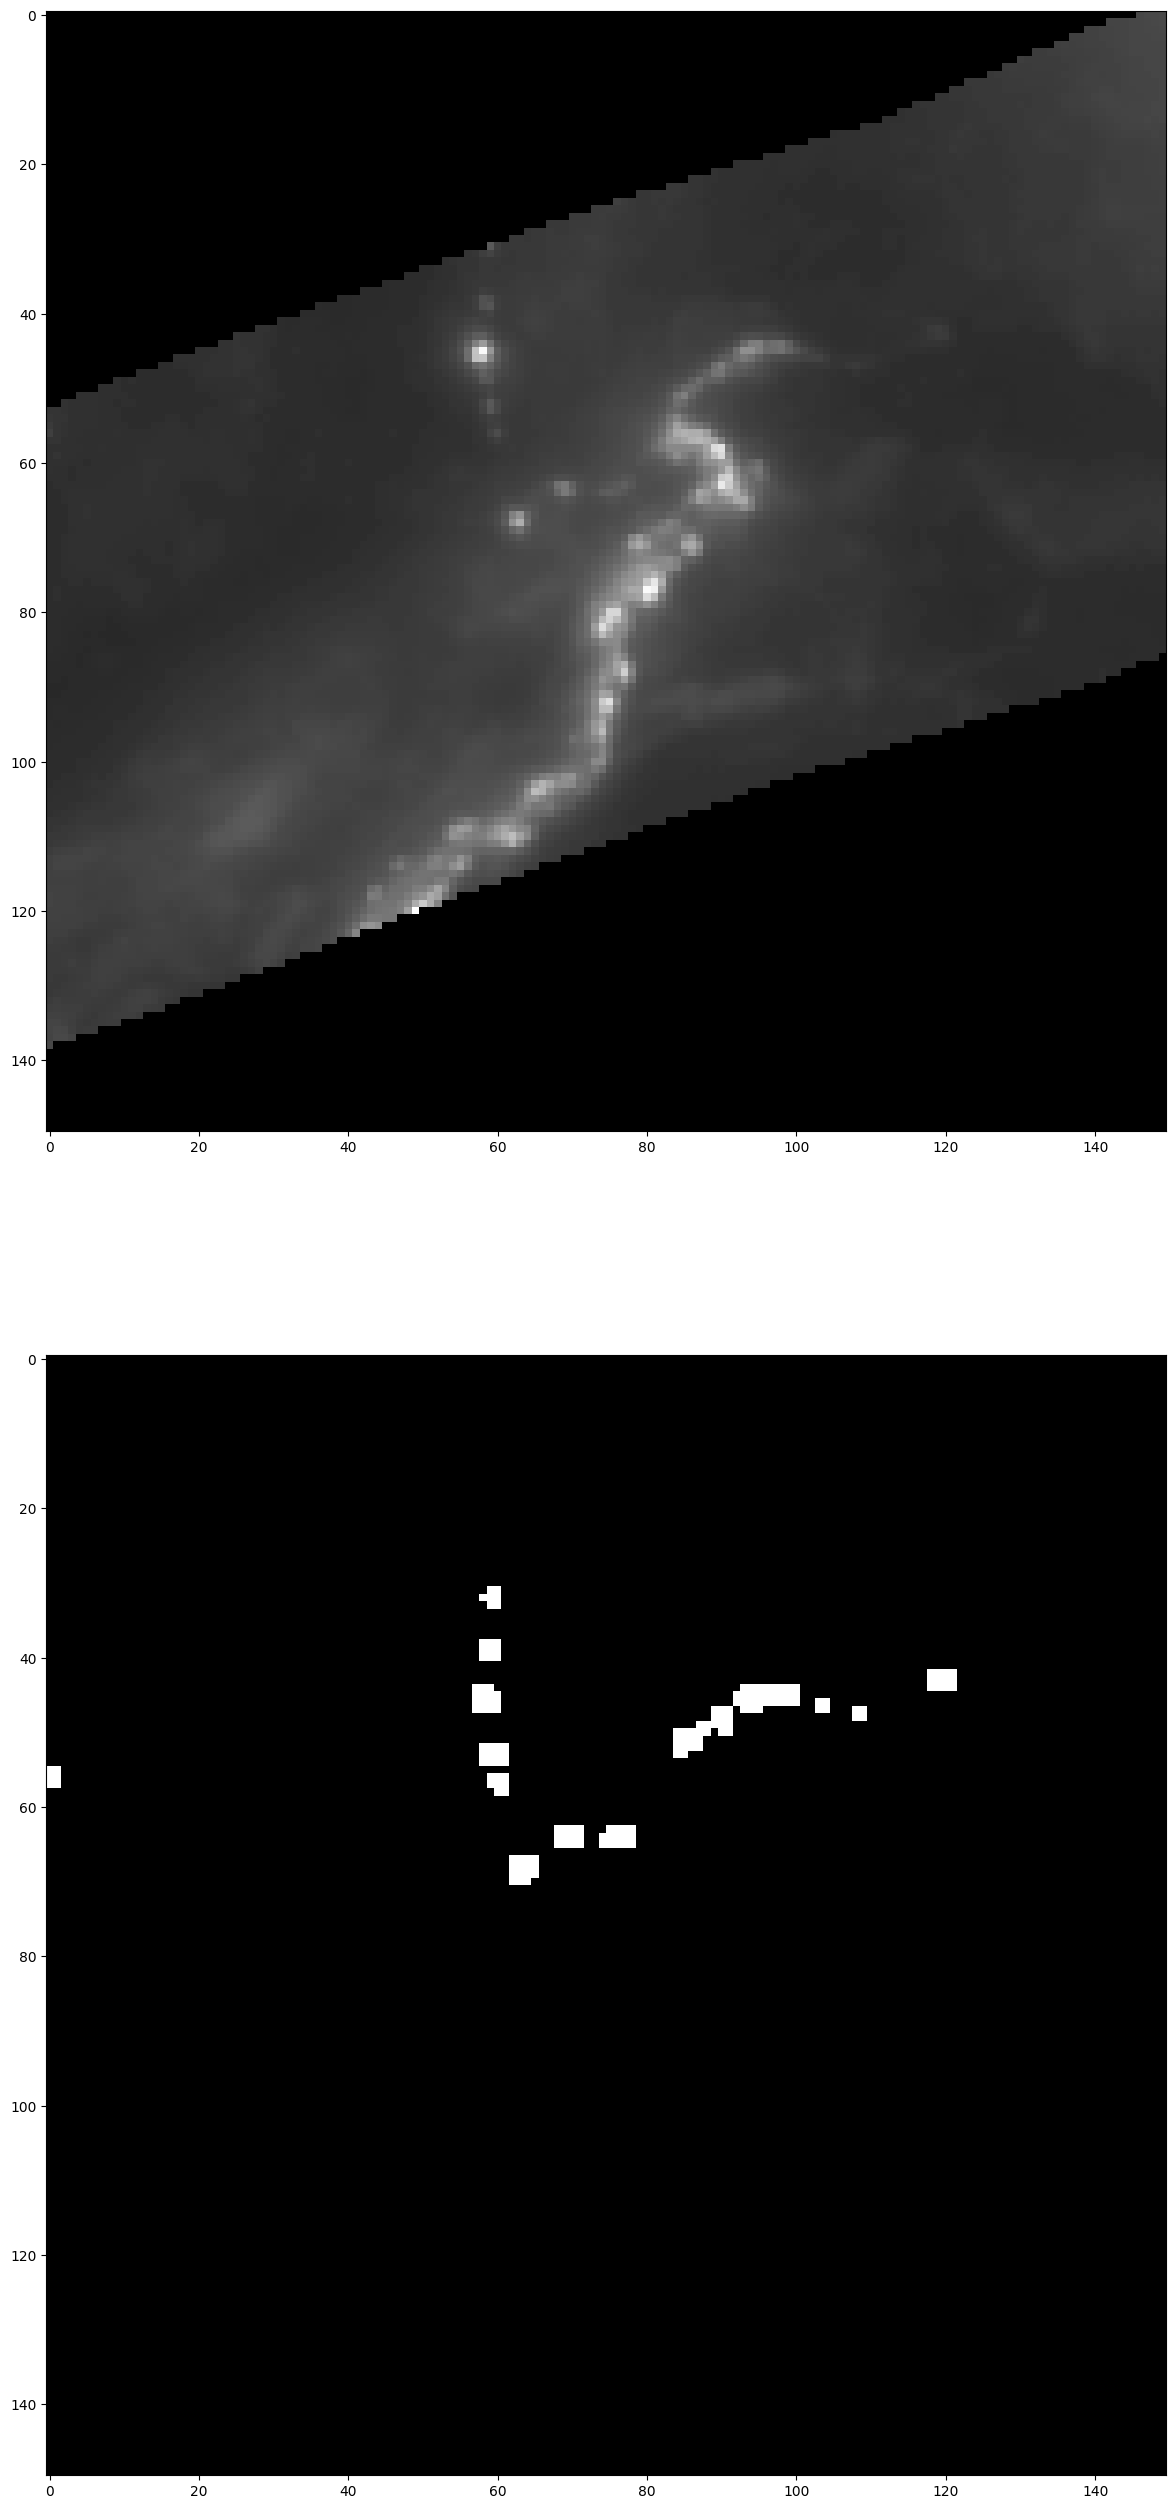

In [2]:
input_image_path = "/home/bl515-ml/Documents/shaio_jie/ienf_q/Centered/processed_S163-2_a.tif"
input_image = Image.open(input_image_path)
input_image = np.array(input_image)


label_image = Image.open(input_image_path.replace(".tif", "_label.tif"))
label_image = np.array(label_image)

mask_image = Image.open(input_image_path.replace(".tif", "_mask.tif"))
mask_image = np.array(mask_image)

plt.figure(figsize=(32, 32))
plt.subplot(2, 1, 1)
plt.imshow(input_image[700:850,1000:1150,1], cmap='gray')
# plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(label_image[700:850,1000:1150], cmap='gray')
# plt.axis('off')
plt.show()

In [3]:
clipped_input = input_image[700:850,1000:1150,1]
clipped_label = label_image[700:850,1000:1150]
clipped_mask = mask_image[700:850,1000:1150]

In [4]:
# get every label connected component
num_labels, labels_im = cv2.connectedComponents(clipped_label.astype(np.uint8))
print("Number of labels: ", num_labels - 1)

# get highest pixel value in each label, and record position of them in an array
highest_pixel_values = []
for label in range(1, num_labels):
	mask = np.zeros(clipped_label.shape, dtype=np.uint8)
	mask[labels_im == label] = 1
	# apply mask to clipped_input
	masked_input = cv2.bitwise_and(clipped_input, clipped_input, mask=mask)
	# get highest pixel value
	highest_pixel_value = np.max(masked_input)
	traget = np.where(masked_input == highest_pixel_value)
	print("Label: ", label, " Highest pixel value: ", highest_pixel_value, " Position: ", traget)
	highest_pixel_values.append((label, highest_pixel_value, traget))
print("Highest pixel values: ", highest_pixel_values)

Number of labels:  13
Label:  1  Highest pixel value:  70  Position:  (array([31]), array([59]))
Label:  2  Highest pixel value:  67  Position:  (array([39]), array([59]))
Label:  3  Highest pixel value:  48  Position:  (array([42]), array([119]))
Label:  4  Highest pixel value:  196  Position:  (array([45]), array([58]))
Label:  5  Highest pixel value:  113  Position:  (array([45, 45]), array([93, 94]))
Label:  6  Highest pixel value:  53  Position:  (array([46]), array([103]))
Label:  7  Highest pixel value:  46  Position:  (array([47]), array([108]))
Label:  8  Highest pixel value:  71  Position:  (array([52]), array([59]))
Label:  9  Highest pixel value:  50  Position:  (array([56]), array([0]))
Label:  10  Highest pixel value:  60  Position:  (array([56]), array([60]))
Label:  11  Highest pixel value:  96  Position:  (array([63, 64]), array([69, 69]))
Label:  12  Highest pixel value:  75  Position:  (array([63]), array([77]))
Label:  13  Highest pixel value:  136  Position:  (arra

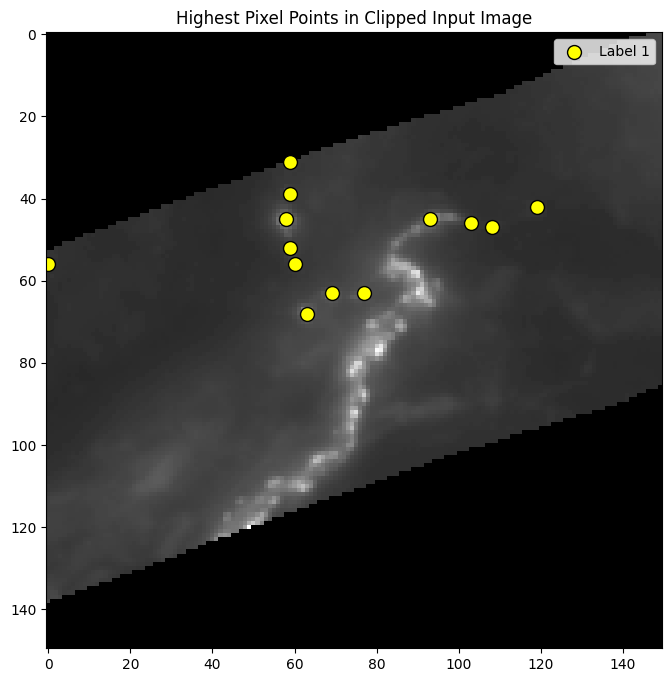

In [5]:
# Draw the highest pixel point for each label on the input image
plt.figure(figsize=(8, 8))
plt.imshow(clipped_input, cmap='gray')

for label, value, position in highest_pixel_values:
	y, x = position[0][0], position[1][0]
	plt.scatter(x, y, color='yellow', s=100, edgecolors='black', label=f'Label {label}' if label == 1 else None)

plt.title('Highest Pixel Points in Clipped Input Image')
plt.legend(loc='upper right')
plt.show()

In [6]:
print(np.max(clipped_input), np.min(clipped_input), np.mean(clipped_input))

201 0 27.167066666666667


In [7]:
import networkx as nx
import heapq
import math
clipped_input = clipped_input.astype(np.float64)

def optimized_std_dijkstra(image, start, end, max_path_length=None):
    rows, cols = image.shape
    
    # 初始化
    costs = np.full((rows, cols), np.inf)
    costs[start] = 0
    priority_queue = [(0, start)]
    came_from = {start: None}
    path_lengths = {start: 1}
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
    start_to_end_distance = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    max_path_length = min(math.ceil(start_to_end_distance * 5), max_path_length) if max_path_length else math.ceil(start_to_end_distance ** 2)

    while priority_queue:
        current_cost, current_node = heapq.heappop(priority_queue)    
        if current_node[0] == end[0] and current_node[1] == end[1]:
            break
        
        for direction in directions:
            neighbor = (current_node[0] + direction[0], 
                       current_node[1] + direction[1])
            
            if (0 <= neighbor[0] < rows and 
                0 <= neighbor[1] < cols and
                image[neighbor] != 0):
                
                new_length = path_lengths[current_node] + 1
                
                # 路徑長度限制檢查
                if max_path_length and new_length > max_path_length:
                    continue
                
                new_cost = abs(int(image[current_node]) - int(image[neighbor])) + path_lengths[current_node]
                
                if new_cost < costs[neighbor]:
                    costs[neighbor] = new_cost
                    came_from[neighbor] = current_node
                    path_lengths[neighbor] = new_length
                    heapq.heappush(priority_queue, (new_cost, neighbor))

    # 安全的路徑重建
    if end not in came_from:
        return [], np.inf
    
    path = []
    current = end
    
    while current is not None:
        if len(path) > max_path_length:
            print("Exceeded max path length during reconstruction.")
            return [], np.inf
        path.append(current)
        current = came_from.get(current)


    path.reverse()
    return path, costs[end]

def astar_image_pathfinding(image, start, end, max_path_length=None):
    """
    針對圖像的 A* 路徑搜索
    成本函數：像素值差異 + 路徑長度
    """
    rows, cols = image.shape
    
    def heuristic(node, goal):
        # 歐幾里得距離作為啟發式
        return math.sqrt((node[0] - goal[0])**2 + (node[1] - goal[1])**2)
    
    # 初始化
    open_set = [(heuristic(start, end), start)]
    came_from = {}
    g_score = {start: 0}
    path_lengths = {start: 1}
    
    # 設定路徑長度限制
    if max_path_length is None:
        distance = math.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
        max_path_length = min(math.ceil(distance ** 2) , 20)
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    while open_set:
        current_f, current = heapq.heappop(open_set)
        
        # 到達目標
        if current == end:
            path = []
            node = current
            while node in came_from:
                path.append(node)
                node = came_from[node]
            path.append(start)
            return path[::-1], g_score[current]
        
        for dx, dy in directions:
            neighbor = (current[0] + dx, current[1] + dy)
            
            # 邊界和障礙物檢查
            if (not (0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols) or 
                image[neighbor] == 0):
                continue
            
            new_length = path_lengths[current] + 1
            
            # 路徑長度限制
            if new_length > max_path_length:
                continue
            
            # 計算實際成本：像素差異 + 路徑長度權重
            pixel_diff = abs(int(image[current]) - int(image[neighbor]))
            tentative_g = g_score[current] + pixel_diff + new_length * 0.1 + (255 - image[neighbor]) * 0.01
            
            # 如果找到更好的路徑
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                path_lengths[neighbor] = new_length
                
                # f = g + h
                f_score = tentative_g + heuristic(neighbor, end)
                heapq.heappush(open_set, (f_score, neighbor))
    
    return [], float('inf')
G = nx.Graph()

# Extract node positions from highest_pixel_values
node_positions = [ (pos[0][0], pos[1][0]) for _, _, pos in highest_pixel_values ]

# Add nodes to graph
for idx, pos in enumerate(node_positions):
	G.add_node(idx, position=pos)

path_dict = {}

# Add edges with weights (pixel value difference)
for i in range(len(node_positions)):
	for j in range(i+1, len(node_positions)):
		pos_i = node_positions[i]
		pos_j = node_positions[j]
		val_i = clipped_input[pos_i]
		val_j = clipped_input[pos_j]

		pos_dis = np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)
		if pos_dis > 20:
			continue  # skip if distance is too far

		print(f"Calculating path from node {i} at {pos_i} with value {val_i} to node {j} at {pos_j} with value {val_j}")
		# res = optimized_std_dijkstra(clipped_input, pos_i, pos_j)
		res = astar_image_pathfinding(clipped_input, pos_i, pos_j)
		path, weight = res
		# print(f"Result: {path[0]} -> {path[1]} nodes, weight {weight}")
		G.add_edge(i, j, weight=weight)
		path_dict[(i, j)] = path
	# 	break  # For testing, only calculate one edge
	# break  # For testing, only calculate one node
		

# Example: Find shortest path between first and last node using Dijkstra
try:
    shortest_path = nx.dijkstra_path(G, source=0, target=len(node_positions)-1, weight='weight')
    print("Shortest path (node indices):", shortest_path)
    print("Shortest path (positions):", [node_positions[i] for i in shortest_path])
except nx.NetworkXNoPath:
    print("No path found.")

Calculating path from node 0 at (np.int64(31), np.int64(59)) with value 70.0 to node 1 at (np.int64(39), np.int64(59)) with value 67.0
Calculating path from node 0 at (np.int64(31), np.int64(59)) with value 70.0 to node 3 at (np.int64(45), np.int64(58)) with value 196.0
Calculating path from node 1 at (np.int64(39), np.int64(59)) with value 67.0 to node 3 at (np.int64(45), np.int64(58)) with value 196.0
Calculating path from node 1 at (np.int64(39), np.int64(59)) with value 67.0 to node 7 at (np.int64(52), np.int64(59)) with value 71.0
Calculating path from node 1 at (np.int64(39), np.int64(59)) with value 67.0 to node 9 at (np.int64(56), np.int64(60)) with value 60.0


Calculating path from node 2 at (np.int64(42), np.int64(119)) with value 48.0 to node 5 at (np.int64(46), np.int64(103)) with value 53.0
Calculating path from node 2 at (np.int64(42), np.int64(119)) with value 48.0 to node 6 at (np.int64(47), np.int64(108)) with value 46.0
Calculating path from node 3 at (np.int64(45), np.int64(58)) with value 196.0 to node 7 at (np.int64(52), np.int64(59)) with value 71.0
Calculating path from node 3 at (np.int64(45), np.int64(58)) with value 196.0 to node 9 at (np.int64(56), np.int64(60)) with value 60.0
Calculating path from node 4 at (np.int64(45), np.int64(93)) with value 113.0 to node 5 at (np.int64(46), np.int64(103)) with value 53.0
Calculating path from node 4 at (np.int64(45), np.int64(93)) with value 113.0 to node 6 at (np.int64(47), np.int64(108)) with value 46.0
Calculating path from node 5 at (np.int64(46), np.int64(103)) with value 53.0 to node 6 at (np.int64(47), np.int64(108)) with value 46.0
Calculating path from node 7 at (np.int64(5

In [8]:
# For each node in G, keep only the shortest path to any other node
shortest_paths = {}
for node in G.nodes:
	min_weight = float('inf')
	min_target = None
	min_path = None
	for target in G.nodes:
		if node != target:
			try:
				path = nx.dijkstra_path(G, source=node, target=target, weight='weight')
				weight = nx.dijkstra_path_length(G, source=node, target=target, weight='weight')
				if weight < min_weight:
					min_weight = weight
					min_target = target
					min_path = path
			except nx.NetworkXNoPath:
				continue
	if min_path is not None:
		shortest_paths[node] = {'target': min_target, 'path': min_path, 'weight': min_weight}

print(shortest_paths)

{0: {'target': 1, 'path': [0, 1], 'weight': np.float64(69.68)}, 1: {'target': 0, 'path': [1, 0], 'weight': np.float64(69.68)}, 2: {'target': 6, 'path': [2, 6], 'weight': np.float64(49.2)}, 3: {'target': 1, 'path': [3, 1], 'weight': np.float64(171.44)}, 4: {'target': 5, 'path': [4, 5], 'weight': np.float64(85.08999999999999)}, 5: {'target': 6, 'path': [5, 6], 'weight': np.float64(27.529999999999998)}, 6: {'target': 5, 'path': [6, 5], 'weight': np.float64(27.529999999999998)}, 7: {'target': 9, 'path': [7, 9], 'weight': np.float64(38.290000000000006)}, 9: {'target': 7, 'path': [9, 7], 'weight': np.float64(38.290000000000006)}, 10: {'target': 11, 'path': [10, 11], 'weight': np.float64(70.30000000000001)}, 11: {'target': 10, 'path': [11, 10], 'weight': np.float64(70.30000000000001)}, 12: {'target': 10, 'path': [12, 10], 'weight': np.float64(125.07)}}


In [9]:
for start in shortest_paths:
	end = shortest_paths[start]['target']
	path = shortest_paths[start]['path']
	print(f"Shortest path from node {start} to node {end}: {path} with weight {shortest_paths[start]['weight']}")

Shortest path from node 0 to node 1: [0, 1] with weight 69.68
Shortest path from node 1 to node 0: [1, 0] with weight 69.68
Shortest path from node 2 to node 6: [2, 6] with weight 49.2
Shortest path from node 3 to node 1: [3, 1] with weight 171.44
Shortest path from node 4 to node 5: [4, 5] with weight 85.08999999999999
Shortest path from node 5 to node 6: [5, 6] with weight 27.529999999999998
Shortest path from node 6 to node 5: [6, 5] with weight 27.529999999999998
Shortest path from node 7 to node 9: [7, 9] with weight 38.290000000000006
Shortest path from node 9 to node 7: [9, 7] with weight 38.290000000000006
Shortest path from node 10 to node 11: [10, 11] with weight 70.30000000000001
Shortest path from node 11 to node 10: [11, 10] with weight 70.30000000000001
Shortest path from node 12 to node 10: [12, 10] with weight 125.07


69.68
69.68
49.2
171.44
85.08999999999999
27.529999999999998
27.529999999999998
38.290000000000006
38.290000000000006
70.30000000000001
70.30000000000001
125.07


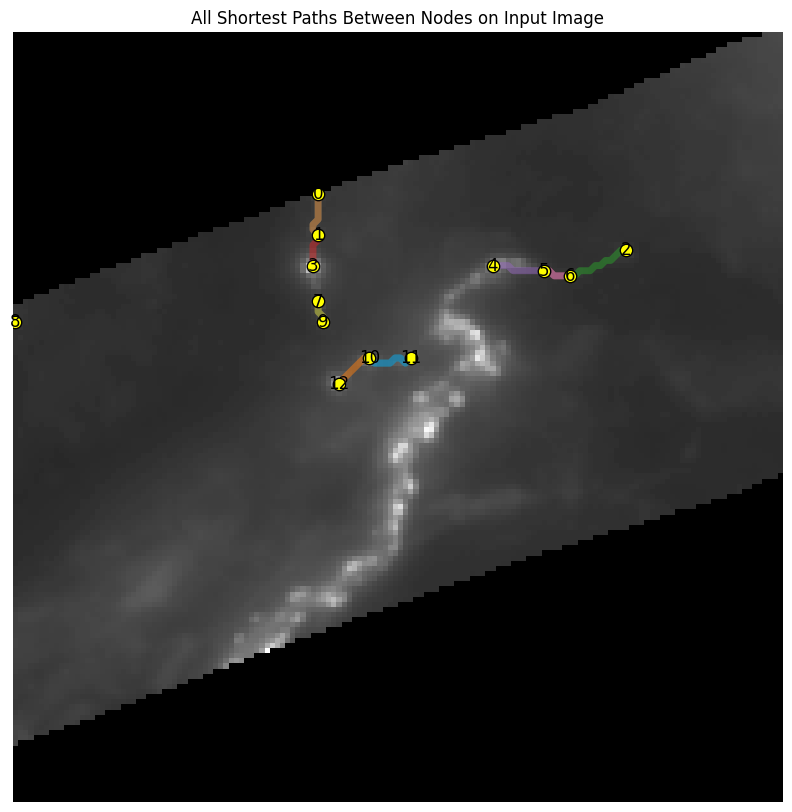

In [10]:
# Draw all shortest paths between node_positions on the original input_image

plt.figure(figsize=(10, 10))
plt.imshow(input_image[700:850,1000:1150,1], cmap='gray')

# Draw all shortest paths found in shortest_paths
for start in shortest_paths:
	end = shortest_paths[start]['target']
	# if shortest_paths[start]['weight'] > 62:
	# 	continue
	print(shortest_paths[start]['weight'])
	path = path_dict.get((start, end)) or path_dict.get((end, start))

	path_rows, path_cols = zip(*path)
	plt.plot(path_cols, path_rows, linewidth=5, alpha=0.5)

# Draw node positions
for idx, pos in enumerate(node_positions):
	plt.scatter(pos[1], pos[0], color='yellow', s=80, edgecolors='black', zorder=3)
	plt.text(pos[1], pos[0], str(idx), color='black', fontsize=12, ha='center', va='center', zorder=4)

plt.title('All Shortest Paths Between Nodes on Input Image')
plt.axis('off')
plt.show()

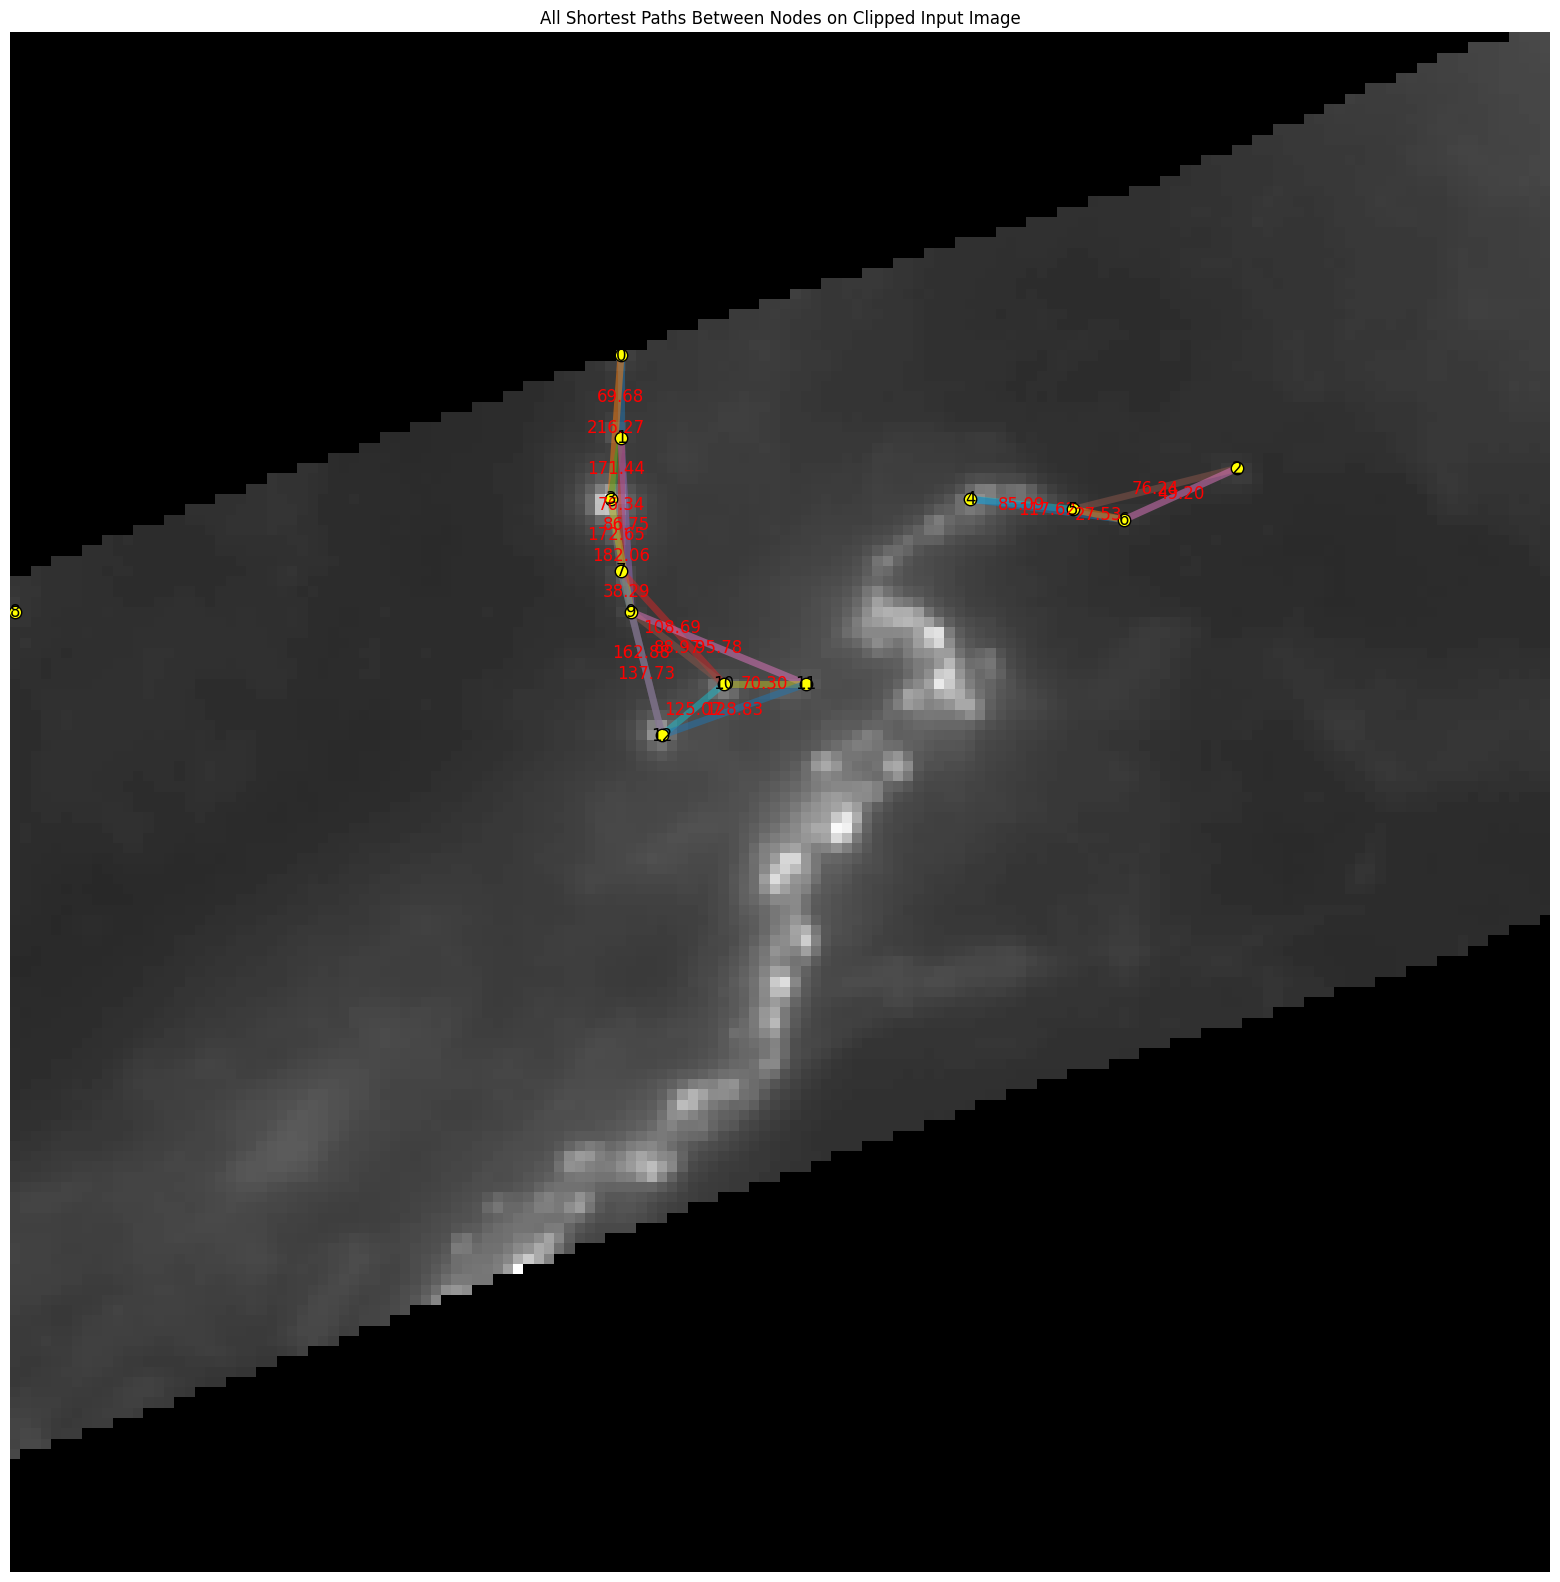

In [24]:
# Draw all shortest paths between node_positions on the clipped_input image

plt.figure(figsize=(20, 20))
plt.imshow(clipped_input, cmap='gray')

# Draw all shortest paths found in path_dict
for (i, j), path in path_dict.items():

	if path:  # Only draw if path exists
		path_rows, path_cols = zip(*path)
		# plt.plot(path_cols, path_rows, linewidth=5, alpha=0.5)
		start_point = (path_cols[0], path_rows[0])
		end_point = (path_cols[-1], path_rows[-1])
		plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linewidth=5, alpha=0.5)
		plt.text((start_point[0]+end_point[0])/2, (start_point[1]+end_point[1])/2, f'{ G.get_edge_data(i, j)["weight"]:.2f}', color='red', fontsize=12, ha='center', va='center', zorder=4)

# Draw node positions
for idx, pos in enumerate(node_positions):
	plt.scatter(pos[1], pos[0], color='yellow', s=80, edgecolors='black', zorder=3)
	plt.text(pos[1], pos[0], str(idx), color='black', fontsize=12, ha='center', va='center', zorder=4)

plt.title('All Shortest Paths Between Nodes on Clipped Input Image')
plt.axis('off')
plt.show()